In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter
import copy

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="data/ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="data/ratings_test.txt")

('data/ratings_test.txt', <http.client.HTTPMessage at 0x22c7f842db0>)

In [3]:
train_data = pd.read_table('data/ratings_train.txt')
test_data = pd.read_table('data/ratings_test.txt')

In [4]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
display(train_data[:5])
print('테스트용 리뷰 개수 :',len(test_data))
display(test_data[:5])

훈련용 리뷰 개수 : 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


테스트용 리뷰 개수 : 50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

총 샘플의 수 : 150000


<Axes: xlabel='label'>

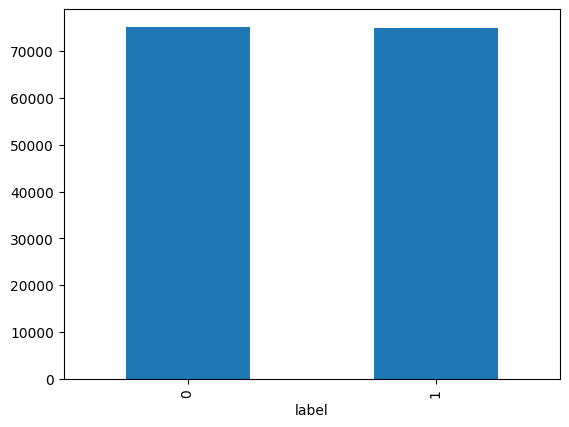

In [6]:
print('총 샘플의 수 :',len(train_data))
train_data['label'].value_counts().plot(kind = 'bar')

In [7]:
print(train_data.groupby('label').size().reset_index(name = 'count'))
print(train_data.isnull().values.any())
print(train_data.isnull().sum())

   label  count
0      0  75173
1      1  74827
True
id          0
document    5
label       0
dtype: int64


In [8]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [9]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [10]:
print(len(train_data))

149995


In [11]:
#알파벳과 공백을 제외하고 모두 제거
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

do you expect people to read the FAQ etc and actually accept hard atheism


In [12]:
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train_data['document'] = train_data['document'].replace('', np.nan)
print(train_data.isnull().sum())

id             0
document    1255
label          0
dtype: int64


In [13]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

148740


In [14]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['document'] = test_data['document'].replace('', np.nan) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


In [15]:
with open('data/stopwords.txt') as f:
    stopwords = [x.replace('\n','') for x in f.readlines()]

In [16]:
print(stopwords)

['거랜데', '로서', '해당', '대해', '갈수', '볼', '박', '점', '결', '뿐', '곤', '배', '편', '까르띠', '척', '찬', '클릭', '요요', '프로필', '두', '도', '드릴', '다그', '로시', '출처', '도', '아이엠', '벤자민', '할애', '채택', '성심', '성의껏', '가지', '제이', '바로가기', '채널', '씨엘', '파', '즐', '안녕하십니까', '질문', '문의', '답변', '굳이', '제공', '최', '나은', '보', '유량', '주시', '현', '쯤', '총', '서나', '아예', '바', '벙', '빼', '곧바로', '나름', '그게', '그냥', '그대로', '그동안', '덜', '스', '놀란', '더욱', '김', '틀', '번의', '나중', '무소', '더니', '무니', '말씀드렷', '보아', '이내', '섣불리', '여러가지', '여지', '진짜', '전혀', '이제', '지금', '이외', '잠도', '일이', '이분', '해도', '워낙', '여럿', '뭔가', '셧습니', '서요', '었어', '어차피', '어처구니', '어쨌든', '살짝', '찾기', '외', '그거', '보이', '한일', '관련', '줌', '료', '뭘', '셨습', '듯', '곳', '려고', '얘기', '몇번', '끝', '때문', '고려', '경우', '거나', '위해', '채', '므', '내', '쪽', '통', '다해', '후', '컴', '니', '못', '취', '끌', '단', '임', '데', '음', '하나요', '고', '끼', '숑', '요', '릐', '청소햐', '가도', '거', '아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면'

In [17]:
okt = Okt()

In [18]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 148740/148740 [04:27<00:00, 555.81it/s]


In [19]:
X_train_test = copy.copy(X_train)
print(id(X_train))
print(id(X_train_test))

2388068628224
2388073517632


In [20]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [01:49<00:00, 447.16it/s]


In [21]:
X_test_test = copy.copy(X_test)
print(id(X_test))
print(id(X_test_test))

2388068628416
2391431563648


In [22]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

In [23]:
print('--------학습 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_train==0)/len(y_train) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_train)/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_val==0)/len(y_val) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_val)/len(y_val) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_test==0)/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_test)/len(y_test) * 100,3)}%')

--------학습 데이터의 비율-----------
부정 리뷰 = 50.153%
긍정 리뷰 = 49.847%
--------검증 데이터의 비율-----------
부정 리뷰 = 50.155%
긍정 리뷰 = 49.845%
--------테스트 데이터의 비율-----------
부정 리뷰 = 49.808%
긍정 리뷰 = 50.192%


In [24]:
word_list = []
for sent in X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 87962


In [25]:
print('훈련 데이터에서의 단어 영화의 등장 횟수 :', word_counts['영화'])
print('훈련 데이터에서의 단어 공감의 등장 횟수 :', word_counts['공감'])

훈련 데이터에서의 단어 영화의 등장 횟수 : 40642
훈련 데이터에서의 단어 공감의 등장 횟수 : 804


In [26]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:20])

등장 빈도수 상위 10개 단어
['영화', '너무', '정말', '적', '연기', '평점', '최고', '잘', '스토리', '생각', '드라마', '게', '감동', '사람', '보고', '하고', '하는', '말', 'ㅋㅋ', '배우']


In [27]:
threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 87962
등장 빈도가 2번 이하인 희귀 단어의 수: 60107
단어 집합에서 희귀 단어의 비율: 68.3329164866647
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.650641916300784


In [28]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))

단어 집합의 크기 : 27855


In [29]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size

27855

In [30]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

In [31]:
for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

In [32]:
vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 27857


In [33]:
print('단어 <PAD>와 맵핑되는 정수 :', word_to_index['<PAD>'])
print('단어 <UNK>와 맵핑되는 정수 :', word_to_index['<UNK>'])
print('단어 영화와 맵핑되는 정수 :', word_to_index['영화'])

단어 <PAD>와 맵핑되는 정수 : 0
단어 <UNK>와 맵핑되는 정수 : 1
단어 영화와 맵핑되는 정수 : 2


In [34]:
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

In [35]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_val, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

In [36]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)

[9242, 11595, 2, 1241, 241, 844, 6, 7774, 6388, 1748]
[499, 975, 6, 835, 1, 12752, 7375, 815, 16090, 31, 121, 743, 3959, 9942, 8227, 584, 584, 499, 1, 6, 1, 1749, 3, 583]


In [37]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [38]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[2]]
print('기존의 첫번째 샘플 :', X_train[2])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플 : ['요즘', '처럼', '자극', '적', '세상', '사는', '영화', '보는', '나마', '마음', '편안하게', '해', '주엇다']
복원된 첫번째 샘플 : ['요즘', '처럼', '자극', '적', '세상', '사는', '영화', '보는', '나마', '마음', '편안하게', '해', '<UNK>']


리뷰의 최대 길이 : 66
리뷰의 평균 길이 : 9.072710770471964


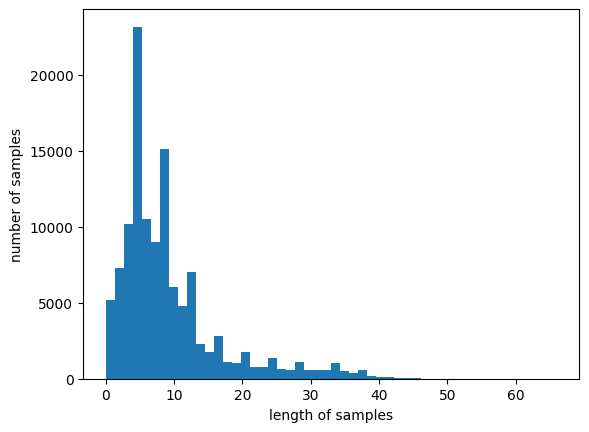

In [39]:
print('리뷰의 최대 길이 :',max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이 :',sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [40]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [41]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 96.5468266774237


In [42]:
test_se = pd.Series(encoded_X_train)
display(test_se)

0         [9242, 11595, 2, 1241, 241, 844, 6, 7774, 6388...
1         [499, 975, 6, 835, 1, 12752, 7375, 815, 16090,...
2         [205, 147, 689, 5, 254, 1076, 2, 55, 4857, 96,...
3                    [415, 4858, 4, 7775, 148, 294, 2, 496]
4                                                    [2080]
                                ...                        
118987                   [509, 5842, 8839, 3628, 172, 1258]
118988               [139, 16558, 101, 80, 24061, 10163, 2]
118989    [6468, 13693, 1893, 10484, 32, 2751, 4836, 272...
118990                                           [77, 1328]
118991    [1, 3105, 1, 6034, 3902, 3384, 18, 2561, 1, 87...
Length: 118992, dtype: object

In [43]:
features = np.zeros((len(test_se), max_len), dtype=int)
features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [44]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (118992, 30)
검증 데이터의 크기 : (29748, 30)
테스트 데이터의 크기 : (48852, 30)


In [45]:
print('첫번째 샘플의 길이 :', len(padded_X_train[0]))
print('첫번째 샘플 :', padded_X_train[0])

첫번째 샘플의 길이 : 30
첫번째 샘플 : [ 9242 11595     2  1241   241   844     6  7774  6388  1748     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [46]:
import numpy as np

# 데이터를 .npz 파일로 저장
np.savez('data/padded_data.npz', 
         padded_X_train=padded_X_train, 
         padded_X_valid=padded_X_valid, 
         padded_X_test=padded_X_test, 
         y_train=y_train, 
         y_valid=y_val, 
         y_test=y_test)